In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas import json_normalize
import pickle
import math
import numpy as np
import os
from datetime import datetime, timedelta
import re

from wordcloud import WordCloud, STOPWORDS
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline  

pd.set_option('max_colwidth', 200)
%config Completer.use_jedi = False
#from helper import toi_add_city_column, hindu_add_city_column, filter_cities

In [34]:
def latexify(fig_width=None, fig_height=None, columns=2):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1,2])

    if fig_width is None:
        fig_width = 3.32 if columns==1 else 6.75 # width in inches

    if fig_height is None:
        golden_mean = (sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches

    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES

    params = {'backend': 'ps',
              'text.latex.preamble': [r'\usepackage{gensymb}'],
              'axes.labelsize': 8, # fontsize for x and y labels (was 10)
              'axes.titlesize': 8,
              'font.size': 8, # was 10
              'legend.fontsize': 8, # was 10
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              'text.usetex': True,
              'figure.figsize': [fig_width,fig_height],
              'font.family': 'serif'
    }

    matplotlib.rcParams.update(params)


def format_axes(ax,twinx=False,SPINE_COLOR="gray"):
    
    if twinx:
        for spine in ['top']:
            ax.spines[spine].set_visible(False)

        for spine in ['left', 'bottom', 'right']:
            ax.spines[spine].set_color(SPINE_COLOR)
            ax.spines[spine].set_linewidth(0.5)
        
    else:
        for spine in ['top', 'right']:
            ax.spines[spine].set_visible(False)

        for spine in ['left', 'bottom']:
            ax.spines[spine].set_color(SPINE_COLOR)
            ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)

    return ax

In [35]:
df_articles = pd.read_csv("../dataset/News_articles_dataset/News_articles_dataset.csv.gz")
df_articles["date"] = pd.to_datetime(df_articles["date"])
df_articles.sample(3)

,media,date,url,heading,content,other.author,other.top_image,other.category,city,year,state,district,matches
1402,TOI,2013-10-31,http://timesofindia.indiatimes.com//city/mumbai/Air-pollution-forecast-for-up-to-three-days-at-10-locations-in-Mumbai-on-anvil/articleshow/24955478.cms,Air pollution forecast for up to three days at 10 locations in Mumbai on anvil,"In a few months, you will know exactly when to keep the pollution masks or inhalers handy. A system being put in place in the city will forecast air quality for up to three days.Screens at 15 majo...","Pratibha Masand / TNN / Oct 31, 2013, 02:59 IST","https://static.toiimg.com/thumb/msid-47529300,width-1070,height-580,imgsize-110164,resizemode-75,overlay-toi_sw,pt-32,y_pad-40/photo.jpg",NaN,mumbai,2013.0,maharashtra,mumbai suburban,"{'air pollution': 4.0, 'air quality': 10.0, 'carbon monoxide': 2.0, 'acid rain': 2.0}"
540,TOI,2011-10-22,http://timesofindia.indiatimes.com//city/mumbai/October-heat-may-benefit-asthma-patients/articleshow/10446440.cms,October heat may benefit asthma patients,"MUMBAI: Asthma patients do not have it easy during Diwali . But, they can relax a little as this time, the festival season has started early, in October. Experts say that with the start of Novembe...","Pratibha Masand / TNN / Oct 22, 2011, 01:21 IST","https://static.toiimg.com/thumb/msid-47529300,width-1070,height-580,imgsize-110164,resizemode-75,overlay-toi_sw,pt-32,y_pad-40/photo.jpg",NaN,mumbai,2011.0,maharashtra,mumbai suburban,{'smog': 1.0}
15210,Hindu,2018-10-13,https://www.thehindu.com/news/national/other-states/punjab-farmers-say-stubble-burning-not-out-of-choice-but-compulsion/article25216639.ece,It’s a foggy autumn as farmers start burning stubble,"With government interventions proving either too expensive or inadequate, Punjab’s farmers have begun burning crop residue, raising fears of pollution.\n\nAs autumn sets in, farmers in Punjab have...",VikasVasudeva,https://www.thehindu.com/news/national/other-states/jxeabe/article25216638.ece/ALTERNATES/LANDSCAPE_615/TH14STUBBLE,other states,rolumajra,NaN,NaN,NaN,"{'air pollution': 2.0, 'stubble burning': 9.0}"


##  Sources

### India

In [36]:

sources_contribution_del = {
    "Residential biomass":23.8,
    "Coal": 9.1, #+ 2.9 + 6.3,      #total coal+ industrical coal + powerplants coal
    "Transportation":3.6, # Transportation+ Distributed diesel
    "Open burning":18.8,
    "Brick production":2.4,
    "Dust":38.1 #+ 13.9 #Anthropogenic dust + total dust
}


df_source_contr_del = pd.DataFrame(sources_contribution_del.items(),columns=["source","perc_contribution"]).nlargest(10,"perc_contribution")
df_source_contr_del

,source,perc_contribution
5,Dust,38.1
0,Residential biomass,23.8
3,Open burning,18.8
1,Coal,9.1
2,Transportation,3.6
4,Brick production,2.4


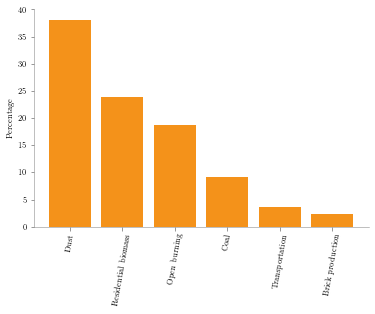

In [37]:
fig,ax = plt.subplots()
#print(total_articles)
#ax.set_title(f"Causes - {total_articles} articles")
ax.bar(df_source_contr_del["source"],df_source_contr_del["perc_contribution"],color="#f4921a")
ax.tick_params(axis="x",rotation=80)
# ax.tick_params(axis="y",labelsize=15)
ax.set_ylabel("Percentage")
#ax.grid(axis="y")
#ax.legend(fontsize=12)
format_axes(ax)
fig.show()

In [38]:

sources_HEI_queries = {
    "Residential biomass":["biomass fuels","wood burning","burning wood","firewood","cooking","household air pollution"], #"biomass burning","biomass combustion","burning of biomass"
    
    "Coal":["[\s,)(-]coal[-\s,)(.]"],
    
    "Transportation": ["vehicles?","petrol","diesel","vehicular emissions"],
    
    
    "Open burning":["open burning","garbage burning","burning garbage","burning waste","waste burning",
                    "burning organic waste","crop burning","stubble","burning crops?","burning paddy",
                    "paddy burning","crop residue"],
    
    "Brick production":["[\s,)(-]brick[\s,)(-s.]"],
    
    "Dust":["[\s,)(-]dust[-\s,)(.]","construction","demolition"],
    
}



In [39]:
def get_regex_string_from_single_word(keyword,space=False,dostrip=True):
    
    #to check empty string before the keyword
    re_str = ""
    space = ""
    if space:
        space = "\\b"
        re_str+=space
    keyword = keyword.lower()
    if dostrip:
        keyword = keyword.strip()
    words = keyword.split(" ")
    n = len(words)
    for ind,word in enumerate(words):
        re_str+=word
        if ind+1 < n:
            #to accept white space between two word
            re_str+="\\s"
    
    #to check empty string after the keyword
    re_str+= space
    return re_str

def get_matches(text,queries,print_re=False,print_matches=False,dostrip=True):
    '''
    regex serach from text using queris
    returns list of keyword matches
    '''
    re_str = ""
    for each in queries:
        re_str = re_str + get_regex_string_from_single_word(each,dostrip) + "|"
    re_str = re_str[:-1]
    if print_re:
        print(re_str)
    if print_matches:
        print(re.findall(re_str,text,flags=re.I))
    return re.findall(re_str,text,flags=re.I)

def get_frequency_of_keyword(df,keyword_dict,column="content",dostrip=True):
    '''
    frequency of keyword from given df using given queries(keyword_dict)
    '''
    keyword_freq = {}
    for key in keyword_dict:
        df[key] = df[column].apply(get_matches,queries=keyword_dict[key],dostrip=dostrip)
        temp_multi = df[df[key].apply(lambda x:len(x)>0)]

        print(f"{key}-{len(temp_multi)}")
        keyword_freq[key] = len(temp_multi)
        
    #transpose & et frquency
    freq_df = pd.DataFrame(keyword_freq,index=range(len(keyword_freq))).T[0]
    freq_df = freq_df.reset_index()
    freq_df.columns = ["keyword","frequency"]
    freq_df = freq_df.sort_values(by="frequency",ascending=False)
    return freq_df


def filter_cities(which_df,allowed_cities):
    '''
    gives only those rows of dataframe which "city" columns
    contains given cities
    allowed cities can be one city or list of cities
    '''
    if type(allowed_cities) == str:
        allowed_cities = [allowed_cities]
    #remove NA values in city
    which_df = which_df.dropna(subset=["city"])

    #city can be list or str
    filtered_df = which_df[which_df["city"].apply(lambda city: True in [each.lower().strip() in city for each in allowed_cities] if type(city) == str or type(city) == list else False)]
    return filtered_df



In [40]:
#get df of frequency of each topic
#sources_freq = h.get_frequency_of_keyword(df_articles,sources_HEI_queries,"heading_and_content")
df_del = filter_cities(df_articles,["delhi","new delhi","newdelhi"])
print(len(df_del))
sources_freq_del = get_frequency_of_keyword(df_del,sources_HEI_queries,"content")

#total_articles = h.get_count_of_total_related_articles(df_del,sources_HEI_queries)
# print(total_articles)

5296
Residential biomass-71
Coal-241
Transportation-1625
Open burning-1242
Brick production-128
Dust-1285


In [41]:
#3115/5201
69/3119

0.0221224751522924

In [42]:
#merged_df = df_source_contr.merge(sources_freq_del,left_on="source",right_on="keyword")
merged_df_del = df_source_contr_del.merge(sources_freq_del,left_on="source",right_on="keyword")


In [43]:
merged_df_del.replace({
    "Residential biomass" : "Residential\nBiomass",
    "Open burning": "Open\nBurning",
    "Brick production": "Brick\nProduction",
    "Transportation": "Vehicular\nEmissions"
}, inplace=True)

In [44]:
#merged_df_del.replace({"Residential\nBiomass":"RB","Open\nBurning":"OB",
#                       "Vehicular\nEmissions":"VE","Brick\nProduction":"BP"},inplace=True)
merged_df_del

,source,perc_contribution,keyword,frequency
0,Dust,38.1,Dust,1285
1,Residential\nBiomass,23.8,Residential\nBiomass,71
2,Open\nBurning,18.8,Open\nBurning,1242
3,Coal,9.1,Coal,241
4,Vehicular\nEmissions,3.6,Vehicular\nEmissions,1625
5,Brick\nProduction,2.4,Brick\nProduction,128


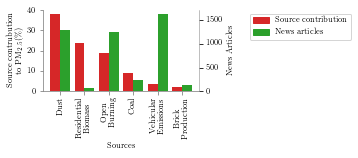

In [46]:
#get count of releted articles
#total_articles = h.get_count_of_total_related_articles(df,sources)
#print(total_articles)

import matplotlib
import matplotlib.pyplot as plt

latexify(columns=1,fig_height=1.5,fig_width=2.8)
which_merged_df = merged_df_del

fig,ax = plt.subplots()
ax2 = ax.twinx()

n_sources = len(which_merged_df)
width = 0.4
x = np.arange(0,n_sources,1)

source_color = "tab:red"
article_color = "tab:green"

#sources contrinbution
ax.tick_params(axis="x",rotation=90)
plt1 = ax.bar(x,which_merged_df["perc_contribution"],color=source_color,label="Source contribution",width=width)
ax.set_ylabel("Source contrubution\nto PM$_{2.5}$(\%)")
ax.set_xlabel("Sources")

#news articles
plt2 = ax2.bar(x+width,which_merged_df["frequency"],label="News articles",width=width,color=article_color)
ax2.set_ylabel("News Articles")

ax.set_xticks(x+width/2)

ax.set_xticklabels(which_merged_df["source"])

format_axes(ax)
plts = plt1+plt2
labels = [plt1.get_label(),plt2.get_label()]
ax.legend(plts,labels,bbox_to_anchor=(2,1))

leg = ax.get_legend()
leg.legendHandles[0].set_color(source_color)
leg.legendHandles[1].set_color(article_color)

for ax in [ax,ax2]:
    for spine in ['top']:
        ax.spines[spine].set_visible(False)

    for spine in ['left', 'bottom', 'right']:
        ax.spines[spine].set_color("gray")
        ax.spines[spine].set_linewidth(0.5)
    

fig.show()
#fig.savefig("plots/latex/sources_barplot.pdf",bbox_inches="tight")

In [ ]:
fig.savefig("../figures/fig8_source_contriution_delhi.pdf",bbox_inches="tight")